In [3]:
# Packages
import h5py
import numpy as np    
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import func as func
from pylab import * 

# To quit warnings for showing up in cell outputs:
import warnings
warnings.filterwarnings('ignore')


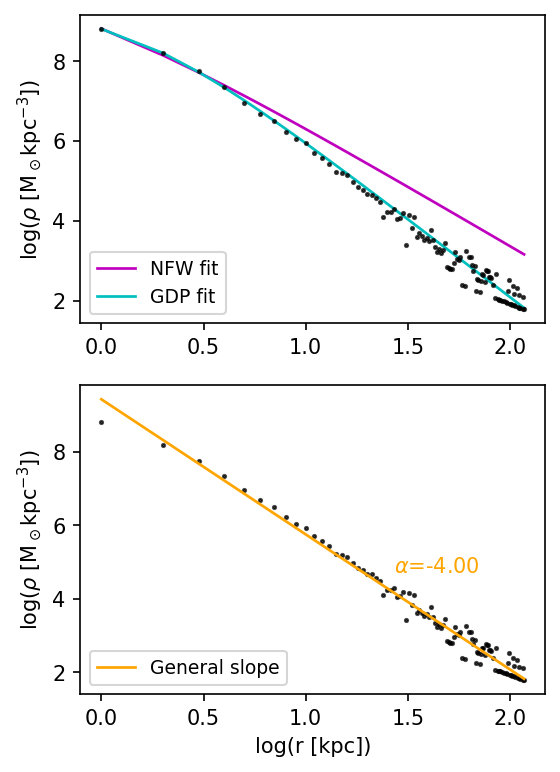

-------------------
NFW fit parameters:
-------------------
log(rho_0) = 9.49
r_s = 0.91

-------------------
GDP fit parameters:
-------------------
log(rho_0) = 9.37
r_s = 1.39
alpha = 1.44
beta = 3.92
gamma = 0.05



In [11]:
#SETTING UP:
    # Directory with data and output filename:
datadir = 'data/v0_n10000/'
filename = 'fit_v0_n10000.png'
savedir = 'results/nfw/'+filename
plot_title = 'v$_0$=0 and n$_{part}$=10000'

    # Import data:
f = h5py.File(datadir+"snapshot_027.hdf5", "r")
group = f["PartType1"]
data = group["Coordinates"][()]




#CALCULATIUNG DENSITY PROFILE:
    # Galaxy center and centered coordinates:
galx,galy,galz=data[:,0],data[:,1],data[:,2]
galcen=[np.median(galx),np.median(galy),np.median(galz)]     # Galaxy center
mp=(1e11)/(len(galx))                                        # Particle mass
galcoords=np.array([galx,galy,galz]) - np.resize(np.array(galcen),(3,1))
galdist = []
for i in range(len(galcoords[0])):
    d=np.sqrt((galcoords[0,i]**2)+(galcoords[1,i]**2)+(galcoords[2,i]**2))
    galdist.append(d)

    # Density profile:
Rbin=1
Rins=1
r,dens=func.dens_prof(Rbin,Rins,galdist,mp)
logr = np.log10(r)
logdens = np.log10(dens)





#FITTING:
    # Fitting density profile to NFW:
p0=[10**6.5,12]
poptNFW, pcov=curve_fit(func.NFW,r,dens,p0,sigma=1/r)
logNFW = np.log10(func.NFW(r,poptNFW[0],poptNFW[1]))

    # Fitting density profile to GDP: (General Density Profile, 3 extra parameters in use)
p0=[poptNFW[0],poptNFW[1],1,3,1]
poptGDP, pcov=curve_fit(func.GDP,r,dens,p0,sigma=1/r,bounds=(0, [10**10,20,6,6,6]))
logGDP = np.log10(func.GDP(r,poptGDP[0],poptGDP[1],poptGDP[2],poptGDP[3],poptGDP[4]))

    # Fitting to exponential at central and outer regions:
pos=func.find_nearest(logr,np.log10(poptNFW[1]))
if pos==0:
    m,b = polyfit(logr,logdens,1)
    y = m*logr + b
else:
    logr1=logr[:pos] ; logr2=logr[pos:]
    logdens1=logdens[:pos] ; logdens2=logdens[pos:]
    m1,b1 = polyfit(logr1,logdens1,1) ; m2,b2 = polyfit(logr2,logdens2,1)
    y1 = m1*logr1 + b1 ; y2 = m2*logr2 + b2





#PLOTTING:
fig = plt.figure(figsize=(4,6),dpi=150)
#fig.suptitle(plot_title)

    #1.Plotting radial profile and models fits:
ax = fig.add_subplot(2, 1, 1)
ax.plot(logr,logNFW,'m-',label='NFW fit',alpha=1,linewidth=1.3)
ax.plot(logr,logGDP,'c-',label='GDP fit',alpha=1,linewidth=1.3)
ax.plot(logr,logdens,'k.',ms=3,alpha=0.7)
#ax.set_xlabel('log(r [kpc])')
ax.set_ylabel('log('+r'$\rho$ [M$_\odot$kpc$^{-3}}$]'+')')
ax.legend(fontsize=9,loc=3)

    #2.Plotting exponential inner and outer regions fit:
ax = fig.add_subplot(2, 1, 2)
ax.plot(logr,logdens,'k.',ms=3,alpha=0.7)
if pos==0:
    ax.plot(logr,y,'-',color='orange',linewidth=1.3,label='General slope')
    ax.text(logr[round(len(logr)/4)],y[round(len(y)/3)]+1,r'$\alpha$='+str('{:.2f}'.format(round(m))),color='orange')
else:
    ax.plot(logr1,y1,'-',color='orange',linewidth=1.3,label='Inner slope')
    ax.text(logr1[round(len(logr1)/3)],y1[round(len(y1)/2)]+0.6,r'$\alpha$='+str('{:.2f}'.format(round(m1))),color='orange')
    ax.plot(logr2,y2,'-',color='seagreen',linewidth=1.3,label='Outer slope')
    ax.text(logr2[round(len(logr2)/4)],y2[round(len(y1)/3)]-0.6,r'$\beta$='+str('{:.2f}'.format(round(m2))),color='seagreen')
    ax.vlines(logr[pos],2,logdens[pos],color='black',linewidth=0.65,alpha=0.5)
    ax.text(logr[pos]-0.05,logdens[round(len(logdens)/3)],'r$_s$='+str('{:.2f}'.format(round(poptNFW[1],3))),size=10,ha='right',alpha=0.5)
ax.set_xlabel('log(r [kpc])')
ax.set_ylabel('log('+r'$\rho$ [M$_\odot$kpc$^{-3}}$]'+')')
ax.legend(fontsize=9,loc=3)

plt.savefig(savedir,layout='tight')
plt.show()





#VALUE OUTPUTS:
    #NFW fit info:
print("-------------------\n"+"NFW fit parameters:\n"+"-------------------\n"+
      "log(rho_0) = "+str('{:.2f}'.format(round(np.log10(poptNFW[0]),3)))+"\nr_s = "+
      str('{:.2f}'.format(round(poptNFW[1],3)))+"\n")

    #GSP fit info:
print("-------------------\n"+"GDP fit parameters:\n"+"-------------------\n"+
      'log(rho_0) = '+str(round(np.log10(poptGDP[0]),2))+"\nr_s = "+
      str('{:.2f}'.format(round(poptGDP[1],3)))+"\nalpha = "+str('{:.2f}'.format(round(poptGDP[2],3)))+"\nbeta = "+
      str('{:.2f}'.format(round(poptGDP[3],3)))+"\ngamma = "+str('{:.2f}'.format(round(poptGDP[4],3)))+"\n")




